## Real Option Data and Implied Volatility


Option Derivatives, their pricing and the implications of their prices on the market are highly complex and created a whole field of financial science. This notebook is supposed to show, how to load real option data over the yahoo finance API in Python. Also it should introduce the topic of implied volatility.

The most common method to price options is based on the Black Scholes Merton formula which can be formulated by this partial differential equation:
### Black Scholes Equation: <br> $ \frac{\partial V }{\partial t} + \frac{1}{2}\sigma^2\frac{\partial^2 V }{\partial S^2} + rS\frac{\partial V }{\partial S} -rV$ = 0

Okay, this looks rather difficult but for now we only need to know that solving thid PDE gives us the actual payoff functions for call and put options:

<br> $ C(S_t,t) = \Phi(d_1)S_t-\Phi(d_2)Ke^{-r(T-t)}$
<br> $ P(S_t,t) = \Phi(-d_2)Ke^{-r(T-t)} - \Phi(-d_1)S_t$, 

where  <br> $ d_1 = \frac{ln\left(\frac{S_t}{K}\right)+\left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \quad \text{and} \quad d_2 = \frac{ln\left(\frac{S_t}{K}\right)+\left(r-q-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} = d_1 - \sigma\sqrt{T-t} $

This formula can be easily implemented within Python. First, however, we load all the required modules.

In [ ]:
!pip install yahoo_fin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader.data as web
from yahoo_fin import options as op
from yahoo_fin import stock_info as stock_info
import plotly.express as px
from tqdm.notebook import tqdm
import plotly.graph_objects as go

We can use the yahoo_fin module to get all kind of data for the most common stocks. This also includes option data. The following lines of code extract the expiration dates of Microsoft Options. This method is equivalent to scraping all of the date selection boxes on the options page for an individual stock. (e.g. https://finance.yahoo.com/quote/MSFT/options?p=MSFT)

In [ ]:
ticker = "MSFT"
expirationDates = op.get_expiration_dates(ticker)
print(f"{expirationDates}\n")
op.get_calls(ticker,date=expirationDates[3])

['April 29, 2022', 'May 6, 2022', 'May 13, 2022', 'May 20, 2022', 'May 27, 2022', 'June 3, 2022', 'June 17, 2022', 'July 15, 2022', 'August 19, 2022', 'September 16, 2022', 'October 21, 2022', 'November 18, 2022', 'January 20, 2023', 'March 17, 2023', 'June 16, 2023', 'January 19, 2024', 'June 21, 2024']



,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,MSFT220520C00140000,2022-04-04 9:55AM EDT,140.0,174.00,141.75,144.90,0.0,-,1,1,119.53%
1,MSFT220520C00145000,2022-03-31 9:30AM EDT,145.0,170.15,137.00,139.70,0.0,-,-,1,0.00%
2,MSFT220520C00150000,2022-04-22 11:19AM EDT,150.0,129.80,132.45,134.60,0.0,-,1,2,0.00%
3,MSFT220520C00155000,2022-03-21 2:16PM EDT,155.0,141.63,129.30,134.00,0.0,-,-,1,153.08%
4,MSFT220520C00160000,2022-03-22 12:53PM EDT,160.0,143.50,124.00,127.55,0.0,-,-,2,129.59%
...,...,...,...,...,...,...,...,...,...,...,...
61,MSFT220520C00405000,2022-04-27 12:53PM EDT,405.0,0.02,0.00,0.08,0.0,-,40,524,51.17%
62,MSFT220520C00410000,2022-04-27 12:59PM EDT,410.0,0.03,0.00,0.08,0.0,-,230,1794,52.73%
63,MSFT220520C00420000,2022-04-27 1:00PM EDT,420.0,0.03,0.00,0.08,0.0,-,110,2219,55.86%
64,MSFT220520C00430000,2022-04-13 2:30PM EDT,430.0,0.03,0.00,0.07,0.0,-,1,600,58.01%


As one can see above, not only the expiration dates but also many other key metrics of options can be obtained by the yahoo_fin module. The table above shows all Microsoft call options currently listed at yahoo finance.

Not only call data but also put data can be obtained by the following methods:

```
yahoo_fin.options.get_calls()
yahoo_fin.options.get_puts()
```

We can see that the table above includes the last trading date but not the expiration date. So it may be useful to include it in the table. This can be done by the following piece of code

In [ ]:
# getting some options data from ticker
ticker = 'MSFT'

# get expiration dates
expirationDates = op.get_expiration_dates(ticker)

# get all data for the options with the (for example) first expiration date
call = op.get_calls(ticker,date=expirationDates[0])
put = op.get_puts(ticker,date=expirationDates[0])
# create a new column that shows the expiration date
call["Exp Date"] = expirationDates[0]
put["Exp Date"] = expirationDates[0]

# Alternatively, we can also do this for all expiration dates (not only the first one)
for i in range(1,len(expirationDates)):
    # added this try and except structure as we don't want the code to crash if 
    # communication errors with the yahoo finance servers occur - This happens sometimes...
    try:
        print(expirationDates[i])
        call1 = op.get_calls(ticker,date=expirationDates[i])
        put1 = op.get_puts(ticker,date=expirationDates[i])
        call1["Exp Date"] = expirationDates[i]
        put1["Exp Date"] = expirationDates[i]
        call=pd.concat([call,call1],ignore_index=True)
        put=pd.concat([put,put1],ignore_index=True)
    except:
        pass

May 6, 2022
May 13, 2022


In a next step we can merge all data into one single dataframe. Before we have to clearly designate put options and call options. Also it is useful to convert dates into a format that can be read by Python.

In [ ]:
call["call_put"] = "call"
put["call_put"] = "put"
df = pd.concat([call,put],ignore_index=True)
df["Last Trade Date"] = pd.to_datetime(df["Last Trade Date"]).dt.date
df

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning:

tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Exp Date,call_put
0,MSFT220429C00180000,2022-04-27,180.0,107.85,0.0,0.0,0.00,-,10,23,0.00%,"April 29, 2022",call
1,MSFT220429C00185000,2022-04-27,185.0,102.85,0.0,0.0,0.00,-,9,16,0.00%,"April 29, 2022",call
2,MSFT220429C00200000,2022-04-27,200.0,80.93,0.0,0.0,0.00,-,4,10,0.00%,"April 29, 2022",call
3,MSFT220429C00210000,2022-04-26,210.0,61.15,0.0,0.0,0.00,-,8,10,0.00%,"April 29, 2022",call
4,MSFT220429C00215000,2022-04-25,215.0,62.78,0.0,0.0,0.00,-,1,11,0.00%,"April 29, 2022",call
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,MSFT240119P00460000,2021-12-30,460.0,133.37,151.0,155.5,0.00,-,1,1,0.00%,"January 19, 2024",put
1676,MSFT240119P00470000,2021-12-17,470.0,157.90,159.5,164.0,0.00,-,1,0,0.00%,"January 19, 2024",put
1677,MSFT240119P00480000,2021-11-01,480.0,160.50,155.5,164.2,0.00,-,1,4,0.00%,"January 19, 2024",put
1678,MSFT240119P00500000,2022-01-04,500.0,180.25,187.0,191.5,0.00,-,1,13,0.00%,"January 19, 2024",put


Next we can visualize, how the latest price of an option relates with its strike price. To do this, we load the historic share prices and merge all the information into a single dataframe.

In [ ]:
# get the microsoft stock data
st = stock_info.get_data(ticker , start_date = '2021-11-01', end_date = '2022-04-30')
df["Last Trade Date"] = pd.DatetimeIndex(df["Last Trade Date"])
idx = pd.DatetimeIndex(df["Last Trade Date"].unique())
merge = pd.merge(df,st["adjclose"],how='left',left_on='Last Trade Date',right_index=True)
#(merge["adjclose"].isna())
merge["Time"]=(pd.DatetimeIndex(merge["Exp Date"])-merge["Last Trade Date"]).dt.days
merge["mean price"] = merge[["Bid","Ask"]].mean(axis=1)
merge["Implied Volatility"] = (merge["Implied Volatility"].str.rstrip('%').astype('float') / 100.0)

In [ ]:
# pool the dates with highest number of strike prices for better illustration 
merge.sort_values(by=["Time","Strike"],inplace=True)
# determine the dates that have more than 50 different strike prices
idy = (merge[["Time","Strike"]].groupby(by="Time").nunique()>=50)
idy = idy[idy==True].dropna().reset_index()
merge = merge[merge["Time"].isin(idy["Time"])].reset_index(drop=True)

fig = px.scatter(merge, x="Strike", y="Last Price", animation_frame="Time",color="call_put")

fig["layout"].pop("updatemenus") 
fig.show()

Yes, that graph is correct - we didn't interchange call and put. You should see that instead of payoff vs terminal price, the axes of this plot are last price vs strike price. And this is logical. The higher the strike price of a call option, the lower will be its payoff and therefore also the current price of this option will be lower.

Next, we will compare the actual price of the options to the theoretical Black-Scholes prices.

In [ ]:
# returns price of an option according to BS
def black_scholes_m(S,K,T,sigma,r,q,o_type = "call"):
    T=T/365
    d_1 = (np.log(S/K)+(r-q+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_2 = (np.log(S/K)+(r-q-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    
    if o_type == "call":
        price = norm.cdf(d_1)*S - norm.cdf(d_2)*K*np.exp(-r*(T))
    elif o_type == "put":
        price = norm.cdf(d_2)*K*np.exp(-r*(T)) - norm.cdf(d_1,)*S
    return np.round(price,4)

# same as above but for multiple values (numpy implementation)
def cont_black_scholes(S,K,T,sigma,r,q,o_type="call"):
    T=T/365
    nom_d1 = (S/K).apply(np.log)+(r-q+0.5*sigma**2).mul(T,axis=0)[0]
    nom_d2 = (S/K).apply(np.log)+(r-q-0.5*sigma**2).mul(T,axis=0)[0]
    denom = sigma.mul(np.sqrt(T),axis=0)[0]
    d_1 = nom_d1.divide(denom,axis=0)
    d_2 = nom_d2.divide(denom,axis=0)

    if o_type == "call":
        price = np.round(norm.cdf(d_1)*S - norm.cdf(d_2)*K*np.exp(-r*(T)),4)
    elif o_type == "put":
        price = np.round(norm.cdf(d_2)*K*np.exp(-r*(T)) - norm.cdf(d_1,)*S,4)
    return price 

# simply creates different levels of sigma for a given bound and 
# applies them to a given dataframe (for simulation/demonstration purposes)
def sigma_gen(df,bound):
    up_bound = bound[1]
    low_bound = bound[0]
    n = len(df["Time"].unique())
    si = np.round(np.linspace(up_bound,low_bound,n),2)
    df["Vol"] = 0
    T = df["Time"].unique()
    for t in range(n):
        df["Vol"][df["Time"]==T[t]] = si[t]
    return df

In [ ]:
merge_c = merge[merge["call_put"]=="call"].reset_index(drop=True)
merge_p = merge[merge["call_put"]=="put"].reset_index(drop=True)

In [ ]:
bound=[0,0.5]
sigma_gen(merge_c,bound)
mp = merge_c["Last Price"]
K = merge_c["Strike"]
T =merge_c["Time"]
S = merge_c["adjclose"]
sigma = merge_c["Vol"]
r = 0.01
q = 0
merge_c["BS Price"]=cont_black_scholes(S,K,T,sigma,r,q)
merge_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Exp Date,call_put,adjclose,Time,mean price,Vol,BS Price
0,MSFT220429C00180000,2022-04-27,180.0,107.85,0.00,0.00,0.00,-,10,23,0.0000,"April 29, 2022",call,283.220001,2,0.000,0.5,103.2299
1,MSFT220429C00185000,2022-04-27,185.0,102.85,0.00,0.00,0.00,-,9,16,0.0000,"April 29, 2022",call,283.220001,2,0.000,0.5,98.2301
2,MSFT220429C00200000,2022-04-27,200.0,80.93,0.00,0.00,0.00,-,4,10,0.0000,"April 29, 2022",call,283.220001,2,0.000,0.5,83.2310
3,MSFT220429C00225000,2022-04-27,225.0,54.80,0.00,0.00,0.00,-,1,6,0.0000,"April 29, 2022",call,283.220001,2,0.000,0.5,58.2323
4,MSFT220429C00230000,2022-04-27,230.0,51.05,0.00,0.00,0.00,-,35,29,0.0000,"April 29, 2022",call,283.220001,2,0.000,0.5,53.2326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,MSFT240119C00460000,2022-01-05,460.0,14.65,14.00,17.00,-2.85,-16.29%,1,348,0.3891,"January 19, 2024",call,315.727173,744,15.500,0.0,0.0000
394,MSFT240119C00470000,2022-01-05,470.0,13.40,10.00,15.00,-2.60,-16.25%,14,227,0.3814,"January 19, 2024",call,315.727173,744,12.500,0.0,0.0000
395,MSFT240119C00480000,2022-01-05,480.0,13.00,11.55,13.50,-3.00,-18.75%,5,457,0.3770,"January 19, 2024",call,315.727173,744,12.525,0.0,0.0000
396,MSFT240119C00500000,2022-01-05,500.0,9.80,9.00,11.00,-1.20,-10.91%,92,1575,0.3699,"January 19, 2024",call,315.727173,744,10.000,0.0,0.0000


In [ ]:
fig = px.scatter(merge_c, x="Strike", y=["Last Price","BS Price"], animation_frame="Time")

fig["layout"]#.pop("updatemenus") # optional, drop animation buttons
fig.show()

As expected, we can see that the more $T$ increases, the more the current price deviates from the actual Black-Scholes price. The reason for this is the fact that until the time to maturity the underlying price might still vary a lot changing the payoff against the favor of the option's seller. Thus, he increases the price of the option. The next graph additionally shows, how different levels of volatility affect the fair option price.

In [ ]:
low_bond_sigma = np.round(np.linspace(0,1,10),3)
merge_c = merge[merge["call_put"]=="call"].reset_index(drop=True)

sigma_var_df = merge_c
for low_b in low_bond_sigma:
    df = merge_c
    bound=[low_b,1+low_b]
    
    sigma_gen(df,bound)
    #print(bound,bound[0],df["Vol"])
    mp = df["Last Price"]
    K = df["Strike"]
    T =df["Time"]
    S = df["adjclose"]
    si = 0.2
    sigma = df["Vol"]
    r = 0.01
    q = 0
    sigma_bounds = "[{},{}]".format(bound[0],bound[1])
    #print(sigma)
    df["BS Price"]=cont_black_scholes(S,K,T,sigma,r,q)
    #print(df[["BS Price","Vol"]])
    df["sigma bounds"] = sigma_bounds
    df["s"] = bound[0]
    sigma_var_df = pd.concat([sigma_var_df,df],ignore_index=True)

In [ ]:
# creating the figures 
figs = [
    px.scatter(sigma_var_df, x="Strike", y=["Last Price","BS Price"], animation_frame=ac)
    # columns that become sliders
    for ac in [ "Time","sigma bounds"]
]

# extract frames and sliders from each of the animated figures
layout = figs[0].to_dict()["layout"]
layout.pop("updatemenus") # don't want play and pause buttons
layout["sliders"] = []
frames = []
for i, f in enumerate(figs):
    slider = f.to_dict()["layout"]["sliders"]
    slider[0]["y"] = -0.6 * i
    slider[0]["x"] = 0
    slider[0]["len"] = 1

    layout["sliders"] += slider
    frames += f.frames

# building the figure with multiple sliders
go.Figure(data=figs[0].data, frames=frames, layout=layout).update_layout(
    margin={"l": 0, "r": 0, "t": 0, "b": 0}, height=400
)

# Implied Volatility

Imagine, a call option expires one week from now with a strike price of $K = 100$ and the current price of the underlying is $S_t = 99$. If this expired today the payoff would be $(S - K)^+ = 0$. But until expiration the underlying's price might still change, so it would be unwise to consider it worthless and just "donate" it to someone.

Now imagine a rational actor does exactly that: he donates the option (or prices it with a price of zero). He might do that based on the assumption that the price of the underlying will not change anymore (thus its volatility is implied to be zero).
On the other hand, if he prices the option with an insanely high price (for example $C = 100$) then one might think that the underlying must be hypervolatile. This summarizes the concept of *implied volatility*.

We can find implied volatility by comparing the current market price of the option with its fair price. In a naive approach, we can simply iterate through the range of possible volatility values and choose the one that minimizes the difference between both prices.

In [ ]:
S_t = 100    # Spot price 
K = 112      # Strike Price
T = 30       # Time to maturity in days
sigma = 0.25 # Volatility
r = 0.05     # Risk free rate
q = 0        # Dividends payout ratio

def bs_price(S,K,T,sigma,r,q,o_type="call"):
    T=T/365

    d_1 = (np.log(S/K) +(r-q+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_2 = (np.log(S/K) +(r-q-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if o_type == "call":
        price = norm.cdf(d_1)*S - norm.cdf(d_2)*K*np.exp(-r*(T))
    elif o_type == "put":
        price = norm.cdf(d_2)*K*np.exp(-r*(T)) - norm.cdf(d_1,)*S
    return np.round(price,4)

def naive_iv(market_p,S_t,K,T,r,q,n):
    diff = [] # Save the absolute differences here 
    sigma = np.linspace(0.01,2,n) # Let's iterate througe the values 0.01 and 2 with n steps 
    for sig in sigma:
        sim_price = bs_price(S_t,K,T,sig,r,q)
        diff.append(abs(market_p - sim_price))
    j = np.argmin(diff)
    return sigma[j]

fairprice = bs_price(S_t,K,T,sigma,r,q)
n = 10000

print(f"The fair call price is:\n{fairprice}\n")
print(f"The implied volatility for a call with price {0.05} is:\n{naive_iv(0.05,S_t,K,T,r,q,n)}\n")
print(f"The implied volatility for a call with price {0.5} is:\n{naive_iv(0.5,S_t,K,T,r,q,n)}\n")

print(f"The implied volatility for a call with the fair price is:\n{naive_iv(fairprice,S_t,K,T,r,q,n)}\n")
fairprice = bs_price(S_t,K,T,0.1,r,q)
print(f"Now change the volatility to {0.1} with the fair price and we get:\n{naive_iv(fairprice,S_t,K,T,r,q,n)}\n")

The fair call price is:
0.21

The implied volatility for a call with price 0.05 is:
0.19110811081108112

The implied volatility for a call with price 0.5 is:
0.3107190719071907

The implied volatility for a call with the fair price is:
0.25001800180018

Now change the volatility to 0.1 with the fair price and we get:
0.01



So we can see that for an option, the implied volatility increases if the option price increases. This makes sense as with higher volatility there are higher potential payoffs for both put and call options wich will increase the option value.

### Newton method
The main problem of the naive iteration method is its very slow runtime. Also, it is limited to the linear scale between 0.01 and 2 in our case and can/will (only) check all of the values in this interval. As this is rather unsatisfying, we need a more efficient way to compute the iplied volatility that requires less iterations. One of the techiques that we can employ is called [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).
Newton-Rapson method is an algorithm from a branch of math called numerical analysis that allows us to approximate the roots(zeros) of a function. For a real-valued function $f$ we take an argument $x_0$ that in our opinion is closest to the function root or at least a good starting point in order to find the value of $x_1$:
<br> $x_1 = x_0 -\frac{f(x_0)}{f'(x_0)}$, 

if the value of $f(x_1)$ is smaller than our tolerated error $\epsilon$ (you can choose it by yourself or take the standard 0.05 or 0.01) then we can end the process; if not, we will repeat it until the condition is satisfied.
In general:
<br>  $x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)}$

We can use our obtained result it in the following way: 

Let $M$ will be our market price and $C(\sigma)$ be the fair price of the same option according to the Black-Scholes formula. In this case we will have:
<br> $f(\sigma):= C(\sigma) - M$
<br> $f'(\sigma)=\frac{\partial C(\sigma)}{\partial \sigma}=\phi(d_1)S_t\sqrt{T-t}$

The partial derivative of an option with respect to the volatility $\sigma$ is often denoted as vega. Now that we have all the required tools to optimize our code above, we will implement them:

In [ ]:
def vega(S,K,T,sigma,r,q,call=True):
    #Calculating d_1 
    d_1 = (np.log(S/K) +(r-q+0.5*sigma**2))/(sigma*np.sqrt(T))
    return S*np.sqrt(T)*norm.pdf(d_1)

def newton_m(market_price,S_t,K,T,r,q,epsilon=0.001): # epsilon is our error term 
    sigma = 0.5 # our intial guess
    diff = 2 # just a placeholder, any number bigger than epsilon works
    # We use the absolute value of the diffenrece because it might be negative 
    while abs(diff) >= epsilon:
        diff = bs_price(S_t,K,T,sigma,r,q) - market_price
        sigma -= diff/vega(S_t,K,T,sigma,r,q)
    return sigma


market_price = 0.05
iv = newton_m(market_price,S_t,K,T,r,q)
print(f"The implied volatility computed with the Newton Method is {iv}")

The implied volatility computed with the Newton Method is 0.19174047920968443


#### Optimization 
As in the previous example we will calculate implied volatility by mininmize the function 
<br> $f(\sigma):= C(\sigma) - M$

or 
<br> $IV = \underset{\sigma \ge 0}{argmin}\{|C(\sigma) - M|\}$.

However, this time we will use an implemented optimization approach by importing a module that optimizes for us.

In [ ]:
from scipy.optimize import minimize_scalar   

def imp_vol(market_price, S, K, T, r, q, o_type = "call"):
    def call_obj(sigma):
        return abs(bs_price(S, K, sigma, T, r, q, o_type ="call") - market_price)
    
    def put_obj(sigma):
        return abs(bs_price(S, K, sigma, T, r, q, o_type ="put") - market_price)
    
    if o_type == 'call':
        diff = minimize_scalar(call_obj, bounds=(0.01,3), method='bounded')
        return diff.x
    elif o_type == 'put':
        diff = minimize_scalar(put_obj, bounds=(0.01,3), method='bounded')
        return diff.x

def IV(market_price,S,K,T,r,q,o_type="call"):
    #T=T/365
    n = S.shape[0] 
    impl_vol = np.zeros(n)
    for i in range(n):
        vol=imp_vol(market_price[i],S[i],K[i],T[i],r,q,o_type="call")
        impl_vol[i]= vol
    return impl_vol

### Volatility smile

In options trading, the volatility smile refers to a phenomenon in which the implied volatility of an option is higher the further it is in the money or out of the money. Conversely, the closer the option is quoted at the money, the lower its implied volatility.

The Volatility Smile thus arises from the fact that the implied volatility as a function of the strike price of an option produces a curve that is reminiscent of a "smile". This article explains why a recognizable smile forms and what this has to do with the implied volatility and the moneyness of options.

In [ ]:
fig = px.scatter(merge, x="Strike", y="Implied Volatility", animation_frame="Time",color="call_put")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

The graph above shows the implied volatilities for different timeframes. However, it does not use our self-created algorithm to compute the implied volatility but the data delivered by yahoo finance. It is quite visible that it does not look quite right, so let's compare the results from our algorithm with the yahoo finance data.

In [ ]:
mp = merge_c["Last Price"]
K = merge_c["Strike"]
T = merge_c["Time"]
S = merge_c["adjclose"]

r = 0.01
q = 0
iv = IV(mp, S, K, T, r, q, o_type = "call")
merge_c["calc IV"] = iv

In [ ]:
mp = merge_p["Last Price"]
K = merge_p["Strike"]
T = merge_p["Time"]
S = merge_p["adjclose"]
r = 0.01
q = 0

iv = IV(mp, S, K, T, r, q, o_type = "put")
merge_p["calc IV"] = iv
calc_iv = pd.concat([merge_c,merge_p],ignore_index=True)

In [ ]:
fig = px.scatter(merge_c, x="Strike", y=["Implied Volatility","calc IV"], animation_frame="Time")
fig["layout"]
fig.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In this graph we can only see the implied volatility for call options. Blue is the implied volatility from yahoo finance and red are the results from our algorithm. We can see that now the implied volatility curve really resembles a "smile".

In [ ]:
fig = px.scatter(calc_iv, x="Strike", y="calc IV", animation_frame="Time",color="call_put")
fig["layout"]
fig.show()

This graph shows again the smile but this time with both call options and put options using our algorithm for the computation of the implied volatility.

Further reading on this topic can be found [here](http://itf.fys.kuleuven.be/~nikos/papers/lect3_smile.pdf).

### Appendix

In [ ]:
rng = np.random.default_rng(123)
T = 30 # in days
mean = 100
std = 5
vol_mean = 0.1
vol_std= 0.15
n = 100

# creating random spot prices ~ N(100, 5)
df = np.round(pd.DataFrame(rng.normal(mean,std,n),columns=["Spot price"]),4)
# creating column with strike prices, all set to 100
df["Strike price"] = np.repeat(100,n)
# creating column with absolute random volatilities ~ N(0.1, 0.15)
df["Volatility"] = np.round(abs(rng.normal(vol_mean,vol_std,n)),4)

def black_scholes_m(S,K,T,sigma,r,q):
    T = T/365 # create yearly measure
    d_1 = (np.log(S/K)+(r-q+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_2 = (np.log(S/K)+(r-q-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    price = norm.cdf(d_1)*S_t - norm.cdf(d_2)*K*np.exp(-r*T)
    return np.round(price,4)

# use results of bs function to create a column with the option prices
df["Option price"] = black_scholes_m(df["Spot price"],df["Strike price"],T,df["Volatility"],r,q)
df.loc[df["Option price"] < 0, "Option price"] = 0
df

,Spot price,Strike price,Volatility,Option price
0,95.0544,100,0.0226,0.0000
1,98.1611,100,0.3487,3.9580
2,106.4396,100,0.0554,0.0824
3,100.9699,100,0.1075,1.2120
4,104.6012,100,0.0578,0.0964
...,...,...,...,...
95,93.8883,100,0.1225,0.2944
96,98.4820,100,0.0762,0.7203
97,94.1316,100,0.0640,0.0038
98,104.1314,100,0.1696,1.4175


,0,1
0,6.968231e-01,3.832248
1,6.843871e-01,3.728457
2,6.714436e-01,3.942168
3,6.595280e-01,3.669392
4,6.471193e-01,3.733495
...,...,...
85,3.724151e-07,0.556955
86,2.320610e-08,0.293678
87,1.140170e-10,0.268590
88,3.721652e-15,0.247550


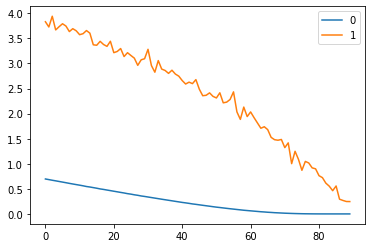

In [ ]:
# multiple time periods 
T=90
mu,sigma = [100,105], [0.2,0.5]
s = np.random.normal(mu, sigma, (T,2))
K = [112,100]
s = pd.DataFrame(s)
si = np.array([0.2,0.21])

def cont_black_scholes(S,K,T,sigma,r,q):
    T=T/365
    t = np.arange(0,T,1/365)
    sigma = pd.DataFrame(np.repeat([si],s.shape[0],axis=0),index=s.index)
    nom_d1 = np.log((s/K))+(r-q+0.5*sigma**2).mul(T-t,axis=0)
    nom_d2 = np.log((s/K))+(r-q-0.5*sigma**2).mul(T-t,axis=0)
    denom = sigma.mul(np.sqrt(T-t),axis=0)

    d_1 = nom_d1/denom
    d_2 = nom_d2/denom

    price = norm.cdf(d_1)*S_t - norm.cdf(d_2)*K*np.exp(-r*T)

    p = pd.DataFrame(price)
    p.plot()
    return p

cont_black_scholes(s,K,T,si,r,q)

